# Outline

1. Create umaps with region color and condition markers for 5xFAD
2. DE tests and heatmaps

- 5xFAD:
   - groups of interest
      - WT Calvaria, WT Femur
      - 5xFAD Calvaria, 5xFAD Femur
   - run tests
      - Calvaria vs Femur within each group (WT, 5xFAD) --> 2 tests, 4 gene lists

In [12]:
from pathlib import Path

import numpy as np
import pandas as pd
import scanpy as sc

from pandas import ExcelWriter

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import colors

plt.rcParams['figure.dpi'] = 110
plt.rcParams['savefig.dpi'] = 150
SMALL_SIZE = 13
MEDIUM_SIZE = 15
BIGGER_SIZE = 17
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


In [3]:
DATA_DIR = "/lustre/groups/ml01/workspace/louis.kuemmerle/projects/A1/data2/"
RESULTS_DIR = "/lustre/groups/ml01/workspace/louis.kuemmerle/projects/A1/results/"

regions = ["Calvaria", "Vertebra", "Scapula", "Femur", "Humerus", "Pelvis","Meninges","Brain"]

In [4]:
region_to_color = {
    "Calvaria"  : "#e377c2",
    "Brain"     : "#1f77b4",
    "Femur"     : "#ff7f0e",
    "Humerus"   : "#279e68",
    "Meninges"  : "#d62728",
    "Pelvis"    : "#aa40fc",
    "Scapula"   : "#8c564b",
    "Vertebra"  : "#b5bd61",
}

condition_to_color = {
    'MCAo'      : "#1f77b4",
    'Naive'     : "#ff7f0e",
    'Sham'      : "#279e68",
}


# 5xFAD

In [28]:
adata = sc.read(Path(DATA_DIR,"5xFAD_data","adata.h5ad"))

### n samples

In [9]:
adata.obs["region_condition"] = adata.obs["region"].astype(str) + "_" + adata.obs["condition"].astype(str)
print("total nr: ",len(adata.obs))
display(adata.obs["region_condition"].value_counts())

total nr:  69


Femur_WT          19
Femur_5xFAD       18
Calvaria_WT       18
Calvaria_5xFAD    14
Name: region_condition, dtype: int64

### Dendrogram

In [29]:
adata.obs["region condition"] = (adata.obs["region"].astype(str) + " " + adata.obs["condition"].astype(str)).astype("category")
sc.tl.dendrogram(adata,"region condition")

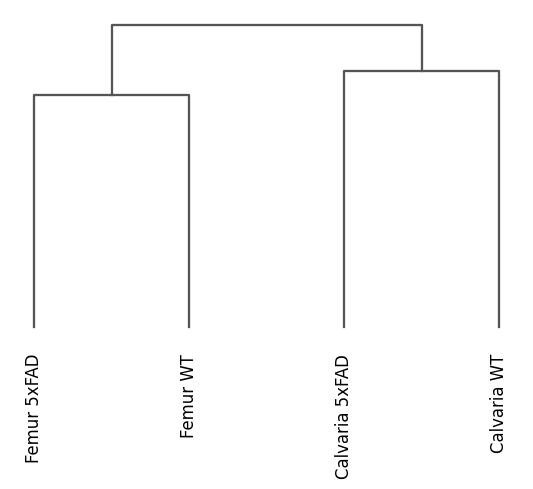

<AxesSubplot:>

In [30]:
sc.pl.dendrogram(adata,"region condition",save="_5xFAD.pdf")

### Umap

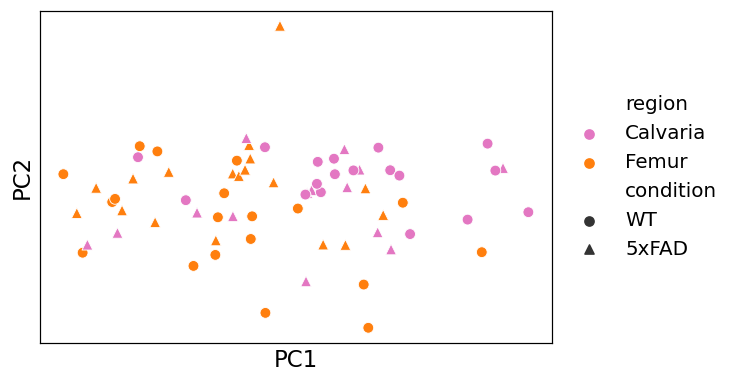

In [21]:
df = pd.DataFrame(
    data = {
        "PC1":adata.obsm["X_pca"][:,0],
        "PC2":adata.obsm["X_pca"][:,1],
        "region":adata.obs["region"].tolist(),
        "condition":adata.obs["condition"].tolist(),
    }
)

sns.scatterplot(
    data=df, x="PC1", y="PC2", hue="region", hue_order=[r for r in regions if r in adata.obs["region"].cat.categories], s=50,
    palette=region_to_color, style="condition", markers={"WT":"o", "5xFAD":"^"}
)
ax = plt.gca()
ax.legend(frameon=False,bbox_to_anchor=(1,0.8))#, loc="lower right")
ax.get_xaxis().set_ticks([])
ax.get_yaxis().set_ticks([])

plt.gcf().savefig("./figures/5xFAD_pca.png", bbox_inches = "tight", transparent=True)
plt.show()

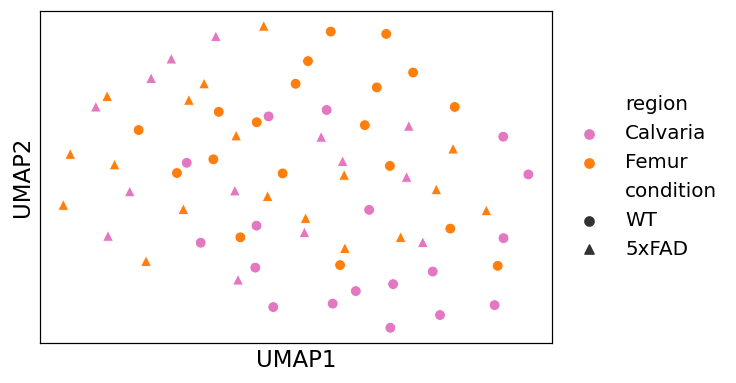

In [32]:
df = pd.DataFrame(
    data = {
        "UMAP1":adata.obsm["X_umap"][:,0],
        "UMAP2":adata.obsm["X_umap"][:,1],
        "region":adata.obs["region"].tolist(),
        "condition":adata.obs["condition"].tolist(),
    }
)

sns.scatterplot(
    data=df, x="UMAP1", y="UMAP2", hue="region", hue_order=[r for r in regions if r in adata.obs["region"].cat.categories], s=50,
    palette=region_to_color, style="condition", markers={"WT":"o", "5xFAD":"^"}
)
ax = plt.gca()
ax.legend(frameon=False,bbox_to_anchor=(1,0.8))#, loc="lower right")
ax.get_xaxis().set_ticks([])
ax.get_yaxis().set_ticks([])

plt.gcf().savefig("./figures/5xFAD_umap.png", bbox_inches = "tight", transparent=True)
plt.show()

### Tests

In [92]:
sc.pp.filter_genes(adata, min_cells = 5)

/opt/python/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [93]:
dfs = {}
    

genes = {}
for cond in adata.obs["condition"].cat.categories:
    
    a_tmp = adata[adata.obs["condition"] == cond].copy()
    sc.tl.rank_genes_groups(a_tmp, "region")
    
    df = sc.get.rank_genes_groups_df(a_tmp, "Calvaria")
    filt_up = (df["logfoldchanges"] > 0) & (df["pvals_adj"] < 0.05)
    filt_down = (df["logfoldchanges"] < 0) & (df["pvals_adj"] < 0.05)
    genes[f"{cond} Calvaria up"] = df.loc[filt_up,"names"].tolist()
    genes[f"{cond} Calvaria down"] = df.loc[filt_down,"names"].tolist()
    print(cond)
    print("n upregulated: ", len(df.loc[filt_up]))
    print("n downregulated: ", len(df.loc[filt_down]))
    
    dfs[f"{cond} Calvaria vs Femur"] = df.loc[filt_up | filt_down]

5xFAD
n upregulated:  0
n downregulated:  0
WT
n upregulated:  11
n downregulated:  12


/opt/python/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [94]:
with ExcelWriter("./5xFAD_DE_genes.xlsx") as writer:
    for sheet, df in dfs.items():
        df.to_excel(writer,sheet)

### Heatmaps

In [59]:
adata.obs["condition region"] = adata.obs["condition"].astype(str) + " " + adata.obs["region"].astype(str)

In [60]:
genes_pl = {}
for key, gs in genes.items():
    if gs:
        genes_pl[key] = gs

... storing 'condition region' as categorical


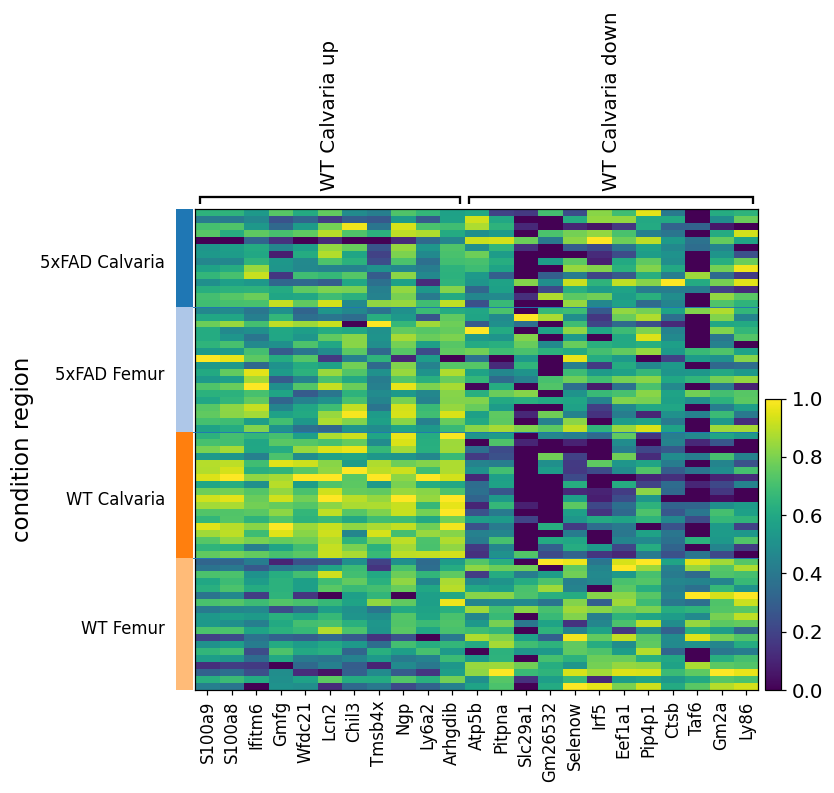

In [61]:
hm = sc.pl.heatmap(adata,genes_pl,"condition region",standard_scale="var",show=False)
plt.gcf().savefig("./figures/5xFAD_heatmap_DE_genes.png", bbox_inches = "tight", transparent=True)
plt.show()